# Test rsfc matrix extraction

Use the default harvard oxford atlas and the power spheres we've defined to ensure fc matrices look about right

In [25]:
import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
%matplotlib inline

%run -i example_sub.py

#grab the harvard oxford labels 
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#create a masker that will allow us to extract signal from rois defined here
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=0)
#initiallize a clean variable to hold the extracted timeseries
time_series = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series = masker.fit_transform(anImg)

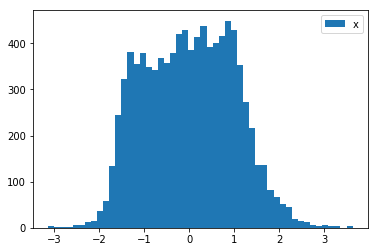

In [26]:
#plot a histogram to check
plt.pyplot.hist(time_series.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

In [27]:
#compute the connectivity matrix
#This uses a slightly regularized correlation estimator
#https://neurostars.org/t/connectivitymeasure-function-in-nilearn-compare-with-corrcoef-in-matlab/3659/2
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, None)

#again, check the hist


/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


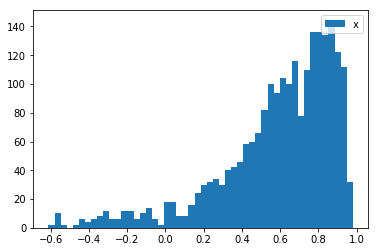

In [28]:
plt.pyplot.hist(correlation_matrix.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()


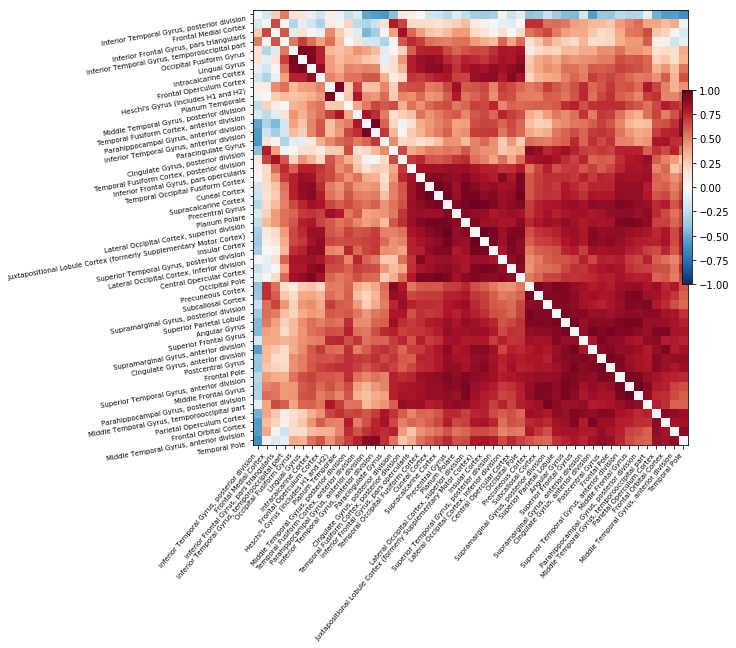

In [29]:
# Plot the correlation matrix
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=True)

# Repeat, but with the parcellation scheme we're using

In [30]:
masker2 = NiftiLabelsMasker(labels_img='../power_spheres/power_drysdale_spheres.nii', standardize=True,
                            memory='nilearn_cache', verbose=0)
time_series2 = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series2 = masker2.fit_transform(anImg)
correlation_matrix2 = correlation_measure.fit_transform([time_series2])[0]

#get our labels -- these are just network labels
power_drysdale_df = pd.read_csv('../power_spheres/power_drysdale_labels.csv', sep=',')
power_drysdale_labels = list(power_drysdale_df['label'].values)

/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


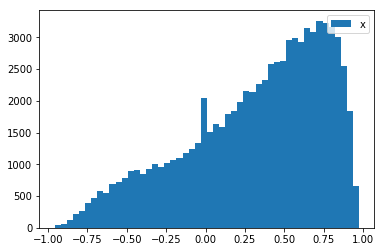

In [31]:
np.fill_diagonal(correlation_matrix2, None)
plt.pyplot.hist(correlation_matrix2.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

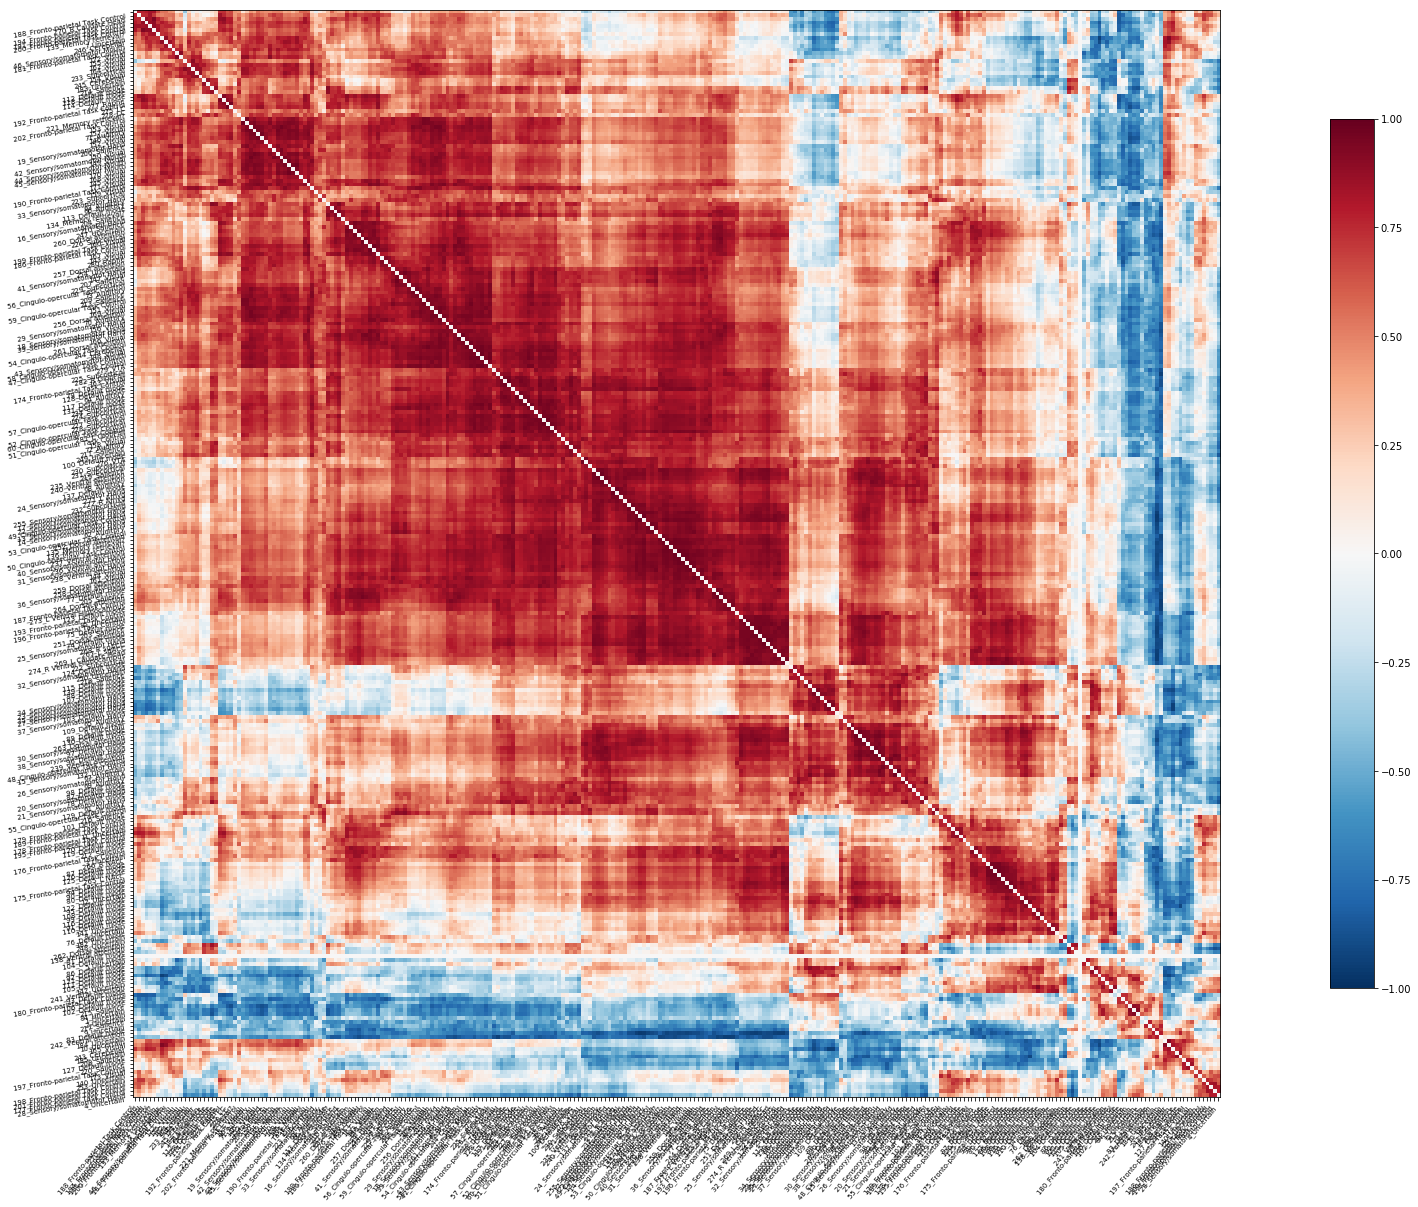

In [33]:
np.fill_diagonal(correlation_matrix2, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix2, figure=(25, 20), labels=power_drysdale_labels,
                     vmax=1, vmin=-1, reorder=True)

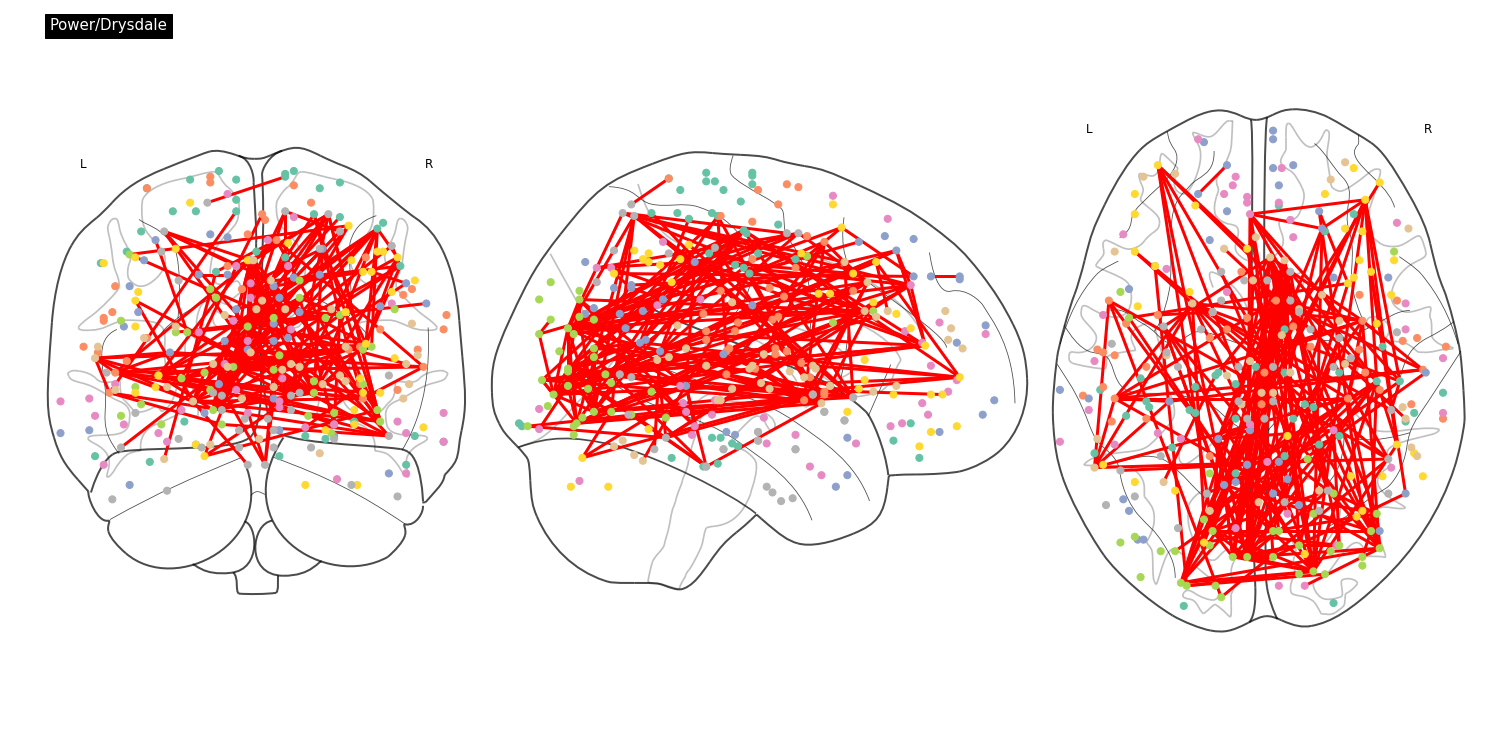

In [9]:
coordinates_power = power_drysdale_df[['X', 'Y', 'Z']].values

fig = plt.pyplot.figure(figsize=(20,10))
plotting.plot_connectome(correlation_matrix2, coordinates_power,
                         figure=fig,
                         edge_threshold="99.5%",
                         node_size=50,
                         title='Power/Drysdale')


# Test Yeo labels

In [10]:
from nilearn.regions import connected_label_regions
yeo = datasets.fetch_atlas_yeo_2011()

In [11]:
yeo_parcels = connected_label_regions(yeo.thick_17, connect_diag=False, min_size=None)

Biggest parcel: 1
Size of voxel in mm: 51.66734399999999


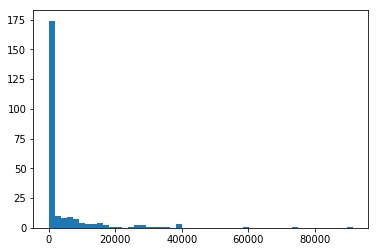

In [12]:
voxel_mm3 = 4*(3.594**2)
unique, counts = np.unique(yeo_parcels.get_data(), return_counts=True)
big_parcel = unique[1:][counts[1:] == max(counts[1:])]
print("Biggest parcel: {}\nSize of voxel in mm: {}".format(big_parcel[0], voxel_mm3))
plt.pyplot.hist(counts[1:], bins=50)
plt.pyplot.show()

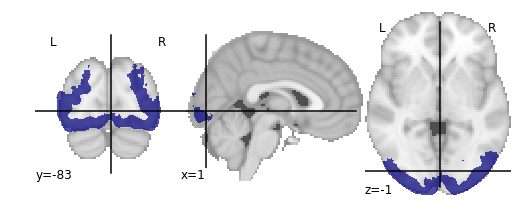

In [13]:
yeo_biggest_parcel = yeo_parcels
yeo_biggest_parcel.dataobj[yeo_biggest_parcel.dataobj != big_parcel] = 0
plotting.plot_roi(yeo_biggest_parcel)

In [14]:
yeo_parcels_gt100 = connected_label_regions(yeo.thick_17, connect_diag=False, min_size=voxel_mm3*2)

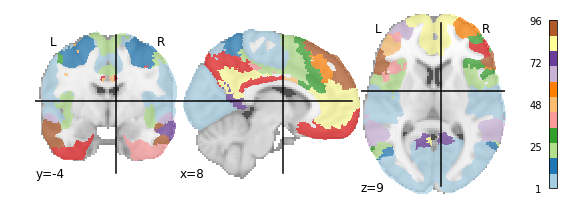

In [15]:
plotting.plot_roi(yeo_parcels_gt100, cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

In [16]:
yeo_parcel_coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo_parcels_gt100)


In [17]:
import pickle
pickle_yeo_out = open("yeo_parcels_gt100.pickle","wb")
pickle.dump({"parcels": yeo_parcels_gt100, 
             "coords": yeo_parcel_coordinates}, 
            pickle_yeo_out)
pickle_yeo_out.close()

In [19]:
# extract time series from all subjects and concatenate them
masker3 = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                            memory='nilearn_cache')
time_series3 = []
# for func, confounds in zip(data.func, data.confounds):
#     time_series.append(masker.fit_transform(func, confounds=confounds))
time_series3 = masker3.fit_transform(anImg)
correlation_matrix3 = correlation_measure.fit_transform([time_series3])[0]
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


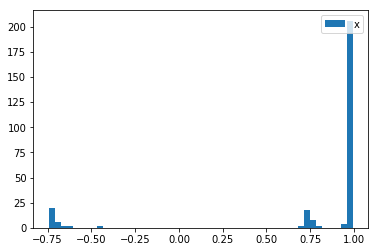

In [20]:
np.fill_diagonal(correlation_matrix3, None)
plt.pyplot.hist(correlation_matrix3.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

In [21]:
coordinates

array([[-26.08691104, -85.02461552,  -1.78400214],
       [-11.44628099, -72.29265921,  11.63924311],
       [-23.1343885 , -25.87231899,  62.18399215],
       [-51.01955636, -15.31800211,  17.39336049],
       [-33.88532586, -65.32925142,  21.65206863],
       [-35.34118839, -41.27366021,  53.67946282],
       [ -8.29614292, -10.1999188 ,  48.98400325],
       [-31.83510638,  43.94603762,  26.82338884],
       [-36.32529883,  -4.7922206 , -33.20359778],
       [-13.49154244,  38.09376098, -17.81067108],
       [ -7.2       , -62.99128329,  43.90072639],
       [-43.51725647,  21.92884832,  23.30442666],
       [-33.26504844,  54.47099162,  -1.80178513],
       [-57.01045038, -32.26328209,   5.17765642],
       [-25.68946598, -31.53365033, -18.04206291],
       [ -8.9324192 ,  51.00526445,   5.98261508],
       [-51.85504422,   3.80310298, -11.67883376]])

In [22]:
yeo_labels = list()
for coords in coordinates:
    yeo_labels.append("_".join("{0}".format(np.round(n,0)) for n in coords))
yeo_labels

['-26.0_-85.0_-2.0',
 '-11.0_-72.0_12.0',
 '-23.0_-26.0_62.0',
 '-51.0_-15.0_17.0',
 '-34.0_-65.0_22.0',
 '-35.0_-41.0_54.0',
 '-8.0_-10.0_49.0',
 '-32.0_44.0_27.0',
 '-36.0_-5.0_-33.0',
 '-13.0_38.0_-18.0',
 '-7.0_-63.0_44.0',
 '-44.0_22.0_23.0',
 '-33.0_54.0_-2.0',
 '-57.0_-32.0_5.0',
 '-26.0_-32.0_-18.0',
 '-9.0_51.0_6.0',
 '-52.0_4.0_-12.0']

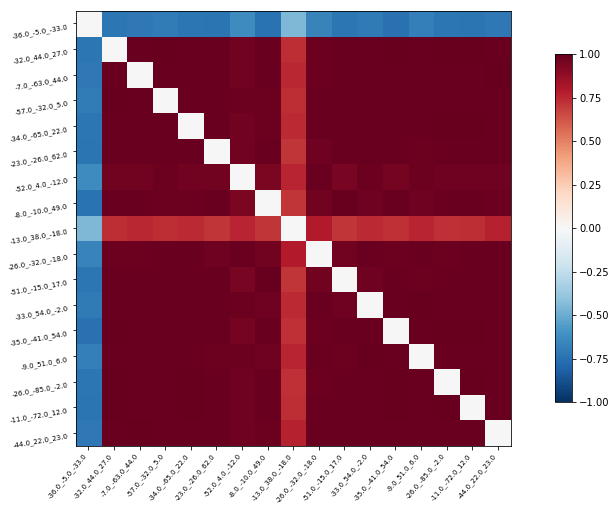

In [23]:
np.fill_diagonal(correlation_matrix3, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix3, figure=(10, 8), labels=yeo_labels,
                     vmax=1, vmin=-1, reorder=True)

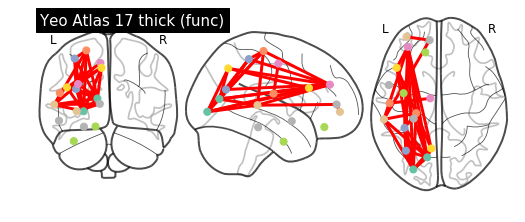

In [24]:
plotting.plot_connectome(correlation_matrix3, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')